## Parameters/Variables for the Training Session

In [1]:
# Model need to be trained
MODEL = "VGNetOrion_extended" #@param ["VGNetOrion_extended", "VGNet_v3"]{type:"string"}
OPTIMIZER = "Adam" # @param ["Adam", "SGD"]{type:"string"}
LEARNING_RATE = 1e-3 # @param ["1e-2","1e-3","1e-4"]{type:"raw"}
#@markdown <pre>Normally LR would be:
#@markdown            <b>0.001</b> for ADAM 
#@markdown       and <b>0.0001</b> with SGD</pre>

# To resume the training set the following, remember to set also the correct MODEL_FILE_GDRIVE_ID for old
epochs= 100 #@param {type:"number"} #100epochs require ~3h for training
old = 0 #@param {type:"number"}

# 2) Fetching model id of GDrive
MODEL_FILE_GDRIVE_ID = "1wbiFUQIqWlIXkxwHBsX95JuRNmTGgDIX"
ROTATED_DATASET = False # True === "output-rotated-v7" False==="output-v3"

best_val_loss = 10#1.6286746263504028 #@param {type:"number"}
best_val_loss_epoc = 0 #@param {type:"number"}

# Put to false if you need to do only the evaluation
TRAIN = True

# If FALSE: 1) disables tqdm LOGGING 
#           2) Re-Fetches model from GDrive
#           2) Saved plot as image
DRAFT_MODE = False  # True = running in background


PRINT = False

# if you want to save models every 100 epochs
SNAPSHOT = True #@param ["True", "False"] {type:"raw"} 
# if you want to save the model on last epoch
RESAVE_LAST_SNAPSHOT = True #@param ["True", "False"] {type:"raw"}  

#params = [{"MODEL":MODEL},{"OPTIMIZER":OPTIMIZER}]#,LEARNING_RATE, epochs, old, best_val_loss, best_val_loss_epoc, DRAFT_MODE, PRINT, SNAPSHOT]
#params = [MODEL,OPTIMIZER,LEARNING_RATE, epochs, old, best_val_loss, best_val_loss_epoc]
print("STARTING WITH params")
#for param in params:
#    param_name = [k for k, v in list(locals().items()) if v == param][0]
#    print(f"  {param_name}:{(16-len(param_name))*' '}{param}")

print(f"  MODEL:{(16-len('MODEL'))*' '}{MODEL}")
print(f"  OPTIMIZER:{(16-len('OPTIMIZER'))*' '}{OPTIMIZER}")
print(f"  LEARNING_RATE:{(16-len('LEARNING_RATE'))*' '}{LEARNING_RATE}")
print(f"  epochs:{(16-len('epochs'))*' '}{epochs}")
print(f"  old:{(16-len('old'))*' '}{old}")
print(f"  best_val_loss:{(16-len('best_val_loss'))*' '}{best_val_loss}")
print(f"  best_val_loss_epoc:{(16-len('best_val_loss_epoc'))*' '}{best_val_loss_epoc}")
print(f"  TRAIN:{(16-len('TRAIN'))*' '}{TRAIN}")
print(f"  DRAFT_MODE:{(16-len('DRAFT_MODE'))*' '}{DRAFT_MODE}")
print(f"  PRINT:{(16-len('PRINT'))*' '}{PRINT}")
print(f"  SNAPSHOT:{(16-len('SNAPSHOT'))*' '}{SNAPSHOT}")

STARTING WITH params
  MODEL:           VGNetOrion_extended
  OPTIMIZER:       Adam
  LEARNING_RATE:   0.001
  epochs:          100
  old:             0
  best_val_loss:   10
  best_val_loss_epoc:0
  TRAIN:           True
  DRAFT_MODE:      False
  PRINT:           False
  SNAPSHOT:        True


In [2]:
#rm -r /kaggle/working/log_*.txt

In [3]:
#ls -lta

## Install & Import

In [4]:
#Install the required packages
print("Installing the required packages...")
#!apt -qq update -y 
#!apt-get -qq install -y libgl1-mesa-glx

!pip install --root-user-action=ignore -q --upgrade jupyter-lsp
!pip install --root-user-action=ignore -q torchsummary
!pip install --root-user-action=ignore -q open3d

if not DRAFT_MODE:
    !pip install --root-user-action=ignore -q gdown

print("Installed all required packages.")

#Import all the packages 
print("Importing the required packages...")
import PIL
import torch
from torch.nn import CrossEntropyLoss, Module, Linear, Sequential, Conv3d, BatchNorm3d, ReLU, MaxPool3d, Dropout, Dropout3d
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, ToTensor
from torch.optim import SGD, Adam
from tqdm import tqdm

from torchsummary import summary

import os
from os import path
import random
from random import sample
from math import floor

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import open3d as o3d

import logging

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support, roc_curve, roc_auc_score
import seaborn as sns


print("Imported all required packages.")

Installing the required packages...
Installed all required packages.
Importing the required packages...
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Imported all required packages.


# Setup

In [5]:
print("SETUP started for the training...")

SETUP started for the training...


### OUTPUT SETTINGS

In [6]:
### KAGGLE folder SETTINGs:
OUTPUT_ROOT_FOLDER = "/kaggle/working/"

#@markdown ---
#@markdown If the Folders doesnt exits they will be created depending on the selected model
#@markdown <pre>     /content/drive/MyDrive/NNDL/Models/{Orion|Our}</pre>
if "Orion".casefold() in MODEL.casefold():
    MODEL_DESTINATION_FOLDER = "NNDL/Model/Orion" 
else:
    MODEL_DESTINATION_FOLDER = "NNDL/Model/Our" 

modelOutputFolder = OUTPUT_ROOT_FOLDER+MODEL_DESTINATION_FOLDER+"/"

# CREATING OUTPUT MODEL FOLDER
os.chdir(OUTPUT_ROOT_FOLDER)
for folder in MODEL_DESTINATION_FOLDER.split("/"):
    if not path.exists(folder):
        os.mkdir(folder)
        print("Making Dir:", folder)
    os.chdir(folder)

# MODEL NAME : model which is modified at every iteration of the training 
#              BEGIN (need MODEL, OPTIMIZER, LEARNING_RATE)
MODEL_NAME_SUFFIX = "" # @param {type:"string"}
modelName = MODEL.casefold()+"_"+OPTIMIZER.casefold()+"_"+'{:.0e}'.format(LEARNING_RATE)

def isNotBlank(s):
    return bool(s and not s.isspace())

if isNotBlank(MODEL_NAME_SUFFIX):
    modelName +="_"+MODEL_NAME_SUFFIX

modelFileName = modelOutputFolder+modelName+".pt" 
print(f"Model will be saved as (AbsolutePath):\n\t '{modelFileName}'")
# MODEL NAME: END

if SNAPSHOT and TRAIN:
    LAST_SNAPSHOT_NAME = modelOutputFolder+modelName+"_"+str(old+epochs)+".pt"
    print(f"Last SNAPSHOT of the model will be saved as (AbsolutePath):\n\t '{LAST_SNAPSHOT_NAME}'")

Model will be saved as (AbsolutePath):	 '/kaggle/working/NNDL/Model/Orion/vgnetorion_extended_adam_1e-03.pt'
Last SNAPSHOT of the model will be saved as (AbsolutePath):	 '/kaggle/working/NNDL/Model/Orion/vgnetorion_extended_adam_1e-03_100.pt'


### INPUT SETTINGS

In [7]:
if ROTATED_DATASET:
    INPUT_ROOT_FOLDER = os.path.dirname("/kaggle/input/output-rotated-v7/Output_ROTATED_v7/")
else:
    INPUT_ROOT_FOLDER = os.path.dirname("/kaggle/input/output-v3/Output_v3/")


### TRAINED MODEL: need modelOutputFolder from OUTPUT SETTINGS
TRAINED_MODEL = f"vgnet_v3_adam_1e-03_{old}.pt"
TRAINED_MODEL_PATH = modelOutputFolder+TRAINED_MODEL

### INPUT DATASET
INPUT_EXTENTION = ".ply" #@param {type:"string"}

# Setting Folders and Classes of the dataset
folders = [dir for dir in sorted(os.listdir(INPUT_ROOT_FOLDER)) if os.path.isdir(os.path.join(INPUT_ROOT_FOLDER,dir))]
classes = {folder:i for i, folder in enumerate(folders)};
print(f'INPUT_ROOT_FOLDER: {INPUT_ROOT_FOLDER}')
print(f'folders: {folders}')
print(f'classes: {classes}')

INPUT_ROOT_FOLDER: /kaggle/input/output-v3/Output_v3
folders: ['bathtub', 'bed', 'chair', 'desk', 'dresser', 'monitor', 'night_stand', 'sofa', 'table', 'toilet']
classes: {'bathtub': 0, 'bed': 1, 'chair': 2, 'desk': 3, 'dresser': 4, 'monitor': 5, 'night_stand': 6, 'sofa': 7, 'table': 8, 'toilet': 9}


## Downloading the TRAINED model from GDrive

Only if we are not in DRAFT_MODE, otherwise we don't need because the state is always put to save

In [8]:
if not DRAFT_MODE and old != 0:
    os.chdir(modelOutputFolder) #MODEL FOLDER
    command = f"gdown {MODEL_FILE_GDRIVE_ID}"
    !{command}
    os.chdir(OUTPUT_ROOT_FOLDER) #OUTPUT FOLDER

# ANOTHER WAY, FROM INPUT FOLDER
# os.system('cp /kaggle/input/vgnet-v3-700/vgnet_v3_adam_1e-03.pt /kaggle/working/NNDL/Model/Our/vgnet_v3_adam_1e-03.pt')
# os.remove(f"{OUTPUT_ROOT_FOLDER}vgnet_v3_adam_1e-03_1000.pt")
# os.chdir("/kaggle/input/output-rotated-v7/") #INPUT
# os.chdir("/kaggle/working") #OUTPUT

# CHECK IF LOADED CORRECTLY
#print("pwd:",os.getcwd())
#print(f"ls {OUTPUT_ROOT_FOLDER}",os.listdir(OUTPUT_ROOT_FOLDER))
#print(f"ls {OUTPUT_ROOT_FOLDER}NNDL/Model/Our/",os.listdir(f"{OUTPUT_ROOT_FOLDER}NNDL/Model/Our/"))

### OTHER SETTINGS

In [9]:
# OTHER SETTINGS
SEED = 7 #@param {type:"number"}
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)


#@markdown <pre>    NUM_WORKERS:  is set to os.cpu_count()
#@markdown     DEVICE:       is set to "CUDA" if runtime is set to GPU
#@markdown     BATCH_SIZE:   is set to 128 if DEVICE is set to "CUDA" otherwise is set to 64</pre>
NUM_WORKERS=os.cpu_count()
device = "cuda" if torch.cuda.is_available() else "cpu"

# BATCH SIZES:
# [32, 64] - CPU | [128, 256] - GPU for more boost
# Tried:
#   batch_size = 64 -> 2.1 GB GPU RAM & 1 Epock 25min & ram di sistema 5.1
#   batch_size = 512 -> 7.2 GB GPU RAM & 1 Epoch 2min & ram system 5.4
# 2.1:15 = 64:x -> 457.14 
#   batch_size = 1000 -> 11.0 GB GPU RAM (error if 2k says that pytorch occupies 6-8GB!)
BATCH_SIZE = 128 if device == "cuda" else 64 

print(f"device:{device}, BATCH_SIZE:{BATCH_SIZE}, NUM_WORKERS:{NUM_WORKERS}")
# OTHER SETTINGS: END

device:cuda, BATCH_SIZE:128, NUM_WORKERS:2


In [10]:
## LOGGER Setting
logger = logging.getLogger(__name__)
logger.handlers.clear()

# Create a custom logger
os.chdir(OUTPUT_ROOT_FOLDER)
if not os.path.isdir("log"):
    os.mkdir("log")

#!rm log/file.log

# Create handlers
f_handler = logging.FileHandler(OUTPUT_ROOT_FOLDER+'log_'+modelName+"_from"+str(old)+"_to"+str(old+epochs)+".txt")
f_handler.setLevel(logging.DEBUG)

# Create formatters and add it to handlers
f_format = logging.Formatter('%(message)s')
f_handler.setFormatter(f_format)

# Add handlers to the logger
logger.addHandler(f_handler)

#!cat log/file.log

In [11]:
print("SETUP finished.")

SETUP finished.


# 1. Dataset & Dataloader

## 1.1 Declaration 

In [12]:
#@title 1.1 Declaration { display-mode: "form" }

# 1.1.2 Transformations
#@markdown <h2>1.1.2 Declaring the Transformations </h2><br>
class Cutout_3d:
    """
    Puts volume to 0 with a percentage 'percentage' in a cutout cube of shape 'cutout_size'

    params percentage,cutout_size
    """

    def __init__(self, percentage=0.2, cutout_size=(8,8,8)):
      self.percentage = percentage
      self.cutout_size = cutout_size

    def __call__(self, volume):
      if random.random() > (1-self.percentage):
        # starting point
        x = np.random.randint(0, 32 - self.cutout_size[0])
        y = np.random.randint(0, 32 - self.cutout_size[1])
        z = np.random.randint(0, 32 - self.cutout_size[2])
        cutout_cube = (x, y, z, self.cutout_size[0], self.cutout_size[1], self.cutout_size[2])
        volume[x:x+self.cutout_size[0], y:y+self.cutout_size[1], z:z+self.cutout_size[2]] = 0
      return volume

class PlyToNumpy:
    """Ges the VoxelGrid From a file and transform it to a np array"""

    def __call__(self, filename):
      if os.path.isfile(filename) and os.path.join(filename).endswith(INPUT_EXTENTION):
        voxelGrid = o3d.io.read_voxel_grid(filename, format='auto', print_progress=True)
        np_voxels = np.array(list(map(lambda x: x.grid_index, voxelGrid.get_voxels())))
        #print(len(np_voxels))

        np_voxelGrid = np.zeros((32, 32, 32))
        for j in range(len(np_voxels)):
          x = np_voxels[j][0]
          y = np_voxels[j][1]
          z = np_voxels[j][2]
          np_voxelGrid[x,y,z] = True #1
          #print(np_voxelGrid)
        
        #print(np_voxelGrid.shape)
        return np_voxelGrid
      else: raise('Not a valid PLY file, is the location correct?')

class ToDType:
    """Cast a tensor to a specific type"""
    def __init__(self, dtype=torch.float):
      self.dtype = dtype

    def __call__(self, tensor):
      return tensor.to(self.dtype)


class AddDummyChannel:
    """Reshape from (32,32,32) to (1,32,32,32)"""

    def __call__(self, tensor):
      return torch.reshape(tensor, (1,32,32,32))

#1.1.3 Voxel Grid Dataset
#@markdown <h2>1.1.3 Declaring Dataset </h2><br>
class VoxelGridDataset(Dataset):
    def __init__(self, dataset_folder, folder="train", transform=None):
        self.dataset_folder = dataset_folder
        folders = [dir for dir in sorted(os.listdir(dataset_folder)) if os.path.isdir(dataset_folder+"/"+dir)]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.transforms = transform
        self.files = []
        for category in classes.keys():
          model_folder = os.path.join(dataset_folder,category,folder)
          for file in os.listdir(model_folder):
            if file.endswith(INPUT_EXTENTION):
              sample = {}
              sample['path'] = os.path.join(model_folder,file)
              sample['category'] = category
              self.files.append(sample)

    def __len__(self):
        return len(self.files)

    def __preproc__(self, file):
        # TODO: IF VALID then don't do train transformation if usesing k-fold
        if self.transforms:
            voxelGrid = self.transforms(file)
        
        # voxelGrid = voxelGrid.to(torch.float) #uint8
        return voxelGrid

    def __onehotencoding__(self, category):
      cat = [0 for _ in range(10)]
      cat[self.classes[category]] = 1
      return torch.tensor(cat, dtype=torch.float) #uint8

    def __getitem__(self, idx):
        path = self.files[idx]['path']
        category = self.files[idx]['category']

        #print(path)
        voxelGrid = self.__preproc__(path)
        category =  self.__onehotencoding__(category) #cant use with crossentropy
        #category = classes[category]
        return voxelGrid, category

## 1.2 Istantiating Dataset & Dataloader

In [32]:
#@title 1.2 Istantiating Dataset & Dataloader{ display-mode: "form" }
#@markdown <h4>1.2.1 Istantiating Dataset </h4>
TrainTransforms = Compose([
    PlyToNumpy(),
    #Cutout_3d(), # RandomErasing(),
    ToTensor(), # this converts numpy or image to torch tensor and normalizes it in 0, 1 
    ToDType(torch.float), #uint8
    AddDummyChannel(),
])

EvalTransforms = Compose([
    PlyToNumpy(),
    # Cutout_3d(), # RandomErasing(),
    ToTensor(), # this converts numpy or image to torch tensor and normalizes it in 0, 1 
    ToDType(torch.float), #uint8
    AddDummyChannel(),
])


train_folder =  VoxelGridDataset(INPUT_ROOT_FOLDER, "train", TrainTransforms)
test_folder =  VoxelGridDataset(INPUT_ROOT_FOLDER, "test",EvalTransforms)
#valid_dataset =  VoxelGridDataset(INPUT_ROOT_FOLDER, "valid", ToTensor())

# 1.2.1 Test Datasets
#@markdown <h5>&nbsp &nbsp &nbsp &nbsp  1.2.1.1 Test Datasets</h5><br>

if PRINT:
    print('Train folder size: ', len(train_folder))
    print('Test folder size: ', len(test_folder))
    print('Number of classes: ', len(train_folder.classes))
    print('Sample VoxelGrid shape: ', train_folder[0][0].shape)
    print('Class: ',train_folder[99][1],"=",folders[train_folder[99][1].argmax()])
    #print('Class: ',folders[train_folder[9900][1]]) # without one hot encoding
    print('VoxelGrid: ', train_folder[99])


# 1.2.2 Dataloader
#@markdown <h4>1.2.2 Dataloader</h4>
#@markdown <pre> DOING as Simone Said, 
#@markdown       80/10/10 fixed otherwize we can try with k-fold on train 
#@markdown       but keep in mind to change the transformers accordingly </pre>
#@markdown &nbsp;&nbsp; &nbsp; Dataloader needs (BATCH_SIZE,NUM_WORKERS)
train_size = len(train_folder)
val_size = int(0.5 * len(test_folder))
test_size = len(test_folder) - val_size

if PRINT: print(train_size, val_size, test_size)

train_set = train_folder
valid_set, test_set = torch.utils.data.random_split(test_folder, [val_size, test_size])

# Istantianting the loaders
train_dataloader = DataLoader(train_set, BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
valid_dataloader = DataLoader(valid_set, min(BATCH_SIZE,len(valid_set)), shuffle=False, num_workers=NUM_WORKERS)
test_dataloader = DataLoader(test_set, min(BATCH_SIZE,len(test_set)), shuffle=False, num_workers=NUM_WORKERS)

#@markdown &nbsp; &nbsp; 1.2.2.1 Check the distribution of the data [TODO]
def get_class_distribution(obj):
    count_dict = {
        "rating_3": 0,
        "rating_4": 0,
        "rating_5": 0,
        "rating_6": 0,
        "rating_7": 0,
        "rating_8": 0,
    }
    
    for i in obj:
        if i == 0: 
            count_dict['rating_3'] += 1
        elif i == 1: 
            count_dict['rating_4'] += 1
        elif i == 2: 
            count_dict['rating_5'] += 1
        elif i == 3: 
            count_dict['rating_6'] += 1
        elif i == 4: 
            count_dict['rating_7'] += 1  
        elif i == 5: 
            count_dict['rating_8'] += 1              
        else:
            print("Check classes.")
            
    return count_dict

count_dict = {folder:0 for i, folder in enumerate(folders)};
if PRINT:
    print(count_dict)

In [33]:
import os
import numpy as np
import open3d as o3d
from pathlib import Path

# TODO: Bring folder creation inside the helper

class HelperClass:
    VOXEL_GRID_SIZE = 32
    SAMPLES = VOXEL_GRID_SIZE**3         # Samples to be sampled from meshes
    VOXEL_SIZE = 1/(VOXEL_GRID_SIZE - 1)        # L/W/H of each voxel --> 1/(voxelGridSize-(1+padding*2)) 0 Padding
    INPUT_EXTENTION = ".off"
    OUTPUT_EXTENTION = ".ply"
    VOXEL_GRID_FOLDER = "Output"

    # TODO remove all classmethods or the constructor
    def __init__(self,VOXEL_GRID_SIZE=32,INPUT_EXTENTION=".off",OUTPUT_EXTENTION = ".ply"):
        self.VOXEL_GRID_SIZE = VOXEL_GRID_SIZE
        self.SAMPLES = VOXEL_GRID_SIZE**3
        self.VOXEL_SIZE = 1/VOXEL_GRID_SIZE
        self.INPUT_EXTENTION = INPUT_EXTENTION
        self.OUTPUT_EXTENTION = OUTPUT_EXTENTION
    
    # TRANSFORMATION METHODS
    # POINT CLOUD
    @classmethod
    def getPointCloudFromMesh(cls,mesh, N=SAMPLES, poisson=False):
        if(poisson):
            return mesh.sample_points_poisson_disk(N)
        return mesh.sample_points_uniformly(number_of_points=N)
    
    @classmethod
    def getVoxelGridFromArray(cls,ThreeDimArray, voxelGridSize=VOXEL_GRID_SIZE, padding=0):
        pc=o3d.geometry.PointCloud()
        pc.points=o3d.utility.Vector3dVector(ThreeDimArray)
        pc.scale(1 / np.max(pc.get_max_bound() - pc.get_min_bound()), center=pc.get_center())

        voxelSize = 1/(voxelGridSize-(1+padding*2))
        return cls.getVoxelGridFromPointCloud(pc,voxelSize)

    # VOXEL GRID
    @classmethod
    def getVoxelGridFromPointCloud(cls,pcd, voxelSize=VOXEL_SIZE):
        return o3d.geometry.VoxelGrid.create_from_point_cloud(pcd,voxel_size=voxelSize)

    @classmethod
    def getVoxelGridFromMesh(cls,mesh, voxelGridSize=VOXEL_GRID_SIZE, padding=0):
        voxelSize = 1/(voxelGridSize-(1+padding*2))
        
        ## Fit to unit cube.
        mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()), center=mesh.get_center())
        return o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size=voxelSize)

    # EXPORT METHODS
    @classmethod
    def exportPointCloud(cls,filename,pointCloud,compressed=False):
        o3d.io.write_point_cloud(filename, pointCloud, write_ascii=True, compressed=compressed, print_progress=True)

    @classmethod
    def exportVoxelGrid(cls,filename,voxelGrid,compressed=False):
        o3d.io.write_voxel_grid(filename, voxelGrid, write_ascii=False, compressed=compressed, print_progress=False)
        
    # IMPORT METHODS
    # MESH from os path
    @classmethod
    def importMesh(cls,filename):
        return o3d.io.read_triangle_mesh(filename)

    @classmethod
    def importPointCloud(cls,filename):
        return o3d.io.read_point_cloud(filename, format='auto',remove_nan_points=False, remove_infinite_points=False, print_progress=True)

    @classmethod
    def importVoxelGrid(cls,filename):
        return o3d.io.read_voxel_grid(filename, format='auto', print_progress=True)

    # UTILs
    @classmethod
    def show(cls,view,standalone=False):
        cls.showComposed([view],standalone)

    @classmethod
    def showComposed(cls,view,standalone=False):
        if(standalone):
            o3d.visualization.draw(view)
        else:
            o3d.visualization.draw_geometries(view)
    
    @classmethod
    def getVGRotated(cls,voxelGrid, voxelGridSize, rx=0,ry=0,rz=0):
        grid_index_array = np.array(list(map(lambda x:x.grid_index,voxelGrid.get_voxels())))
        
        # getting rotation matrix see https://en.wikipedia.org/wiki/Rotation_matrix
        R = np.eye(3) # ID matrix, can also use np.zeros((3,3))
        
        a = rz
        b = ry
        g = rx
        R[0, 0] = np.cos(a)*np.cos(b)
        R[0, 1] = np.cos(a)*np.sin(b)*np.sin(g)-np.sin(a)*np.cos(g)
        R[0, 2] = np.cos(a)*np.sin(b)*np.cos(g)+np.sin(a)*np.sin(g)
        R[1, 0] = np.sin(a)*np.cos(b)
        R[1, 1] = np.sin(a)*np.sin(b)*np.sin(g)+np.cos(a)*np.cos(g)
        R[1, 2] = np.sin(a)*np.sin(b)*np.cos(g)-np.cos(a)*np.sin(g)
        R[2, 0] = -np.sin(b)
        R[2, 1] = np.cos(b)*np.sin(g)
        R[2, 2] = np.cos(b)*np.cos(g)
        
        return cls.getVoxelGridFromArray(R.dot(grid_index_array.T).T, voxelGridSize)
    
    @classmethod
    def describeVoxels(cls,voxels,voxelGridSize, displayMin=True, displayMax=True,):
        displayTotal=True
        maxArray = np.array([0, 0, 0],np.int32)
        minArray = np.array([voxelGridSize, voxelGridSize,voxelGridSize],np.int32)

        array = np.zeros((voxelGridSize,voxelGridSize,voxelGridSize,1))
        for i in range(len(voxels)): 
            x,y,z = voxels[i].grid_index
            array[x][y][z] = 1
            maxArray = np.maximum(maxArray, voxels[i].grid_index)
            minArray = np.minimum(minArray, voxels[i].grid_index)

        # to check
        tot = 0
        for x,y,z in ((a,b,c) for a in range (voxelGridSize) for b in range (voxelGridSize) for c in range (voxelGridSize)):
            value = array[x][y][z]
            if value > 0:
                #print(x,y,z,value)
                tot += 1
        
        string = f'totalVoxels={tot}' if displayTotal else ""
        string += f', maxArray={maxArray}' if displayMax else ""
        string += f', minArray={minArray}' if displayMin else ""
        final_str = f'{string}'

        #print(final_str)

        voxelgrid_np = np.array(list(map(lambda x:x.grid_index,voxels)))
        mean = np.mean(voxelgrid_np, axis=0)
        std = np.std(voxelgrid_np, axis=0)

        print("m:",mean,"std:",std)
Helper = HelperClass()

In [34]:
def arrayOf(voxelGrid):
    return np.array(list(map(lambda x:x.grid_index,voxelGrid.get_voxels())))
def voxelGridOf(arr):
    output = []
    for i,a in enumerate(arr):
        for j,b in enumerate(a):
            if b.any():
                for k,c in enumerate(b):
                    output.append([i,j,k])
    return np.array(output)

def xyzOf(arr):
    x = [] 
    y = []
    z = []
    max = 8
    for i,a in enumerate(arr):
        for j,b in enumerate(a):
                for k,c in enumerate(b):
                    if c:
                        if max<10:
                            max += 1
#                             print(i,a)
#                             print(j,b)
#                             print(k,c)

#                             print(k,j,i)
                        x.append(k)
                        y.append(j)
                        z.append(i)

    return x,y,z

In [35]:
if PRINT:
    # todo remove abs path, wont work with Output_v3
    vg = Helper.importVoxelGrid("/kaggle/input/output-rotated-v7/Output_ROTATED_v7/bathtub/test/bathtub_0107_120.ply")
    X = []
    Y = []
    Z = []
    voxels = vg.get_voxels()
    for i in range(len(voxels)): 
        x,y,z = voxels[i].grid_index
        X.append(x)    
        Y.append(y)
        Z.append(z)

    # print(X)
    # print(Y)
    # print(Z)
    fig = plt.figure(figsize=(20,20))
    ax = plt.axes(projection='3d')
    ax.view_init(40, 30)
    # ax.dist = 4
    #for i in range(len(x)):
        #print(x[i],y[i],z[i])
    ax.scatter3D(X,Y,Z, c='red');
    # ax.can_zoom()

In [36]:
if PRINT:
    np_voxels = np.array(list(map(lambda x: x.grid_index, vg.get_voxels())))
    #print(len(np_voxels))

    np_voxelGrid = np.zeros((32, 32, 32))
    for j in range(len(np_voxels)):
      x = np_voxels[j][0]
      y = np_voxels[j][1]
      z = np_voxels[j][2]
      np_voxelGrid[x,y,z] = True #1
      if x < 1:print(x,y,z)

    #print(np_voxelGrid.shape)
    print(np_voxelGrid[11][7][0])

In [37]:
if PRINT:
    # todo remove index out of bound with Output_v3
    toiletIDX = 0
    monitorIDX = 5100
    print(folders[train_folder[toiletIDX][1].argmax()])
    print(folders[train_folder[monitorIDX][1].argmax()])

    toilet = train_folder[toiletIDX][0].numpy().squeeze()
    monitor = train_folder[monitorIDX][0].numpy().squeeze()

    print("TOILET",toilet[0][0])
    print("MONITOR",monitor[0][0])

    #print(sample)
    x,y,z = xyzOf(toilet)

    #print(x,"\n",y,"\n",z)
    #print("mm")
    x,y,z = xyzOf(monitor)

    #print(x,"\n",y,"\n",z)

In [38]:
if PRINT:
    fig = plt.figure(figsize=(20,20))
    ax = plt.axes(projection='3d')
    ax.view_init(40, 30)
    # ax.dist = 4
    #for i in range(len(x)):
        #print(x[i],y[i],z[i])
    ax.scatter3D(x,y,z, c='red');
    # ax.can_zoom()


In [39]:
if PRINT:
    vg = Helper.importVoxelGrid("/kaggle/input/output-rotated-v7/Output_ROTATED_v7/bathtub/test/bathtub_0107_120.ply")
    #o3d.visualization.draw([vg])
    #print(vg[0])
    #o3d.visualization.draw_geometries([vg])

In [40]:
if PRINT:
    sample_ply_data = o3d.data.PLYPointCloud()
    pcd = o3d.io.read_point_cloud(sample_ply_data.path)
    downpcd = pcd.voxel_down_sample(voxel_size=0.02)
    o3d.visualization.draw_plotly([downpcd],
                                 zoom=0.3412,
                                 front=[0.4257, -0.2125, -0.8795],
                                 lookat=[2.6172, 2.0475, 1.532],
                                 up=[-0.0694, -0.9768, 0.2024])

# 2. Model Definition

In [41]:
#@title 2. Model Definition { display-mode: "form" }
#@markdown <h3>2.0 Defining Utils</h3>

def calculateKernelSize(inKerDim,kernels,paddings,strides):
    if len(kernels) != len(paddings) != len(strides):
        return -1
  
    currentDim = inKerDim
    string = f'{currentDim}'
    
    for i in range(len(kernels)):
        k = kernels[i]
        p = paddings[i]
        s = strides[i]
        currentDim = floor((currentDim+2*p-k)/s+1)
        string += f' -> {currentDim}' 
    if PRINT: print(string)
    return currentDim

def calculateTensorDimention(kernelSize, kernelDim, lastLayerFiltersSize):
    return (kernelSize**kernelDim)*lastLayerFiltersSize

def getDimCNN(dim=32,kernel=3,stride=1,padding=0):
    """[(W−K+2P)/S]+1.
        dim is the input volume
        kernel is the Kernel size
        padding is the padding
        stride is the stride"""
    n = ((dim-kernel+2*padding)/stride)+1
    return n

if PRINT:
    print("getDimCNN(32,3,2,0):",getDimCNN(32,3,2,0))
    print("getDimCNN(64,3,1,0):",getDimCNN(64,3,1,0))
    inputDim = 32
    ## ORION ##
    filters = [32,64,128,256,   ] #out of the layer, last = pool2
    kernels = [3,  3,  3,  3,  2]
    strides = [2,  1,  1,  1,  2]
    paddings= [0,  0,  0,  0,  0]
    k = kernels #[elem for temp in zip(kernels,maxPoolKernels) for elem in temp]
    s = strides #[elem for temp in zip(strides,maxPoolStrides) for elem in temp]
    p = paddings #[elem for temp in zip(paddings,maxPoolPaddings) for elem in temp]

    print(k,s,p)
    ker = calculateKernelSize(inputDim,k,p,s)
    print("ker(ORION)=",ker)
    flattenVolume = calculateTensorDimention(ker,3,filters[-1])
    print("flattenVolume(ORION)=",flattenVolume)

    ## V3 ##
    filters = [16,32,64]
    kernels = [3,3,3]
    strides = [1,1,1] #32-->16 (if s=2)
    paddings = [1,1,1]
    dropoutRatios = [0.2,0.2,0.2]
    maxPoolKernels = [3,3,3]
    maxPoolStrides = [3,3,3] # H/3 -->
    maxPoolPaddings = [0,0,0]

    k = [elem for temp in zip(kernels,maxPoolKernels) for elem in temp]
    p = [elem for temp in zip(paddings,maxPoolPaddings) for elem in temp]
    s = [elem for temp in zip(strides,maxPoolStrides) for elem in temp]
    print(k,s,p)
    ker = calculateKernelSize(inputDim,k,p,s)
    print("ker(V3)=",ker)
    flattenVolume = calculateTensorDimention(ker,3,filters[-1])
    print("flattenVolume(V3)=",flattenVolume)

#@markdown ---
#@markdown <h3>2.1 Compiled Models:</h3>
#@markdown <h4>&nbsp; &nbsp;VGNet_v3</h4>

class VGNet_v3(Module):
  def __init__(self):
      super().__init__()

      # CONVs
      in_channels = 1
      voxelGridSize = 32
      voxelGridDim = 3 # 32x32x32

      filters = [32,64,128]
      kernels = [3,3,3]
      strides = [1,1,1] #32-->16 (if s=2)
      paddings = [1,1,1]
      dropoutRatios = [0.2,0.2,0.2]
      maxPoolKernels = [2,2,2]
      maxPoolStrides = [2,2,2] # H/3 -->
      maxPoolPaddings = [0,0,0]

      k = [elem for temp in zip(kernels,maxPoolKernels) for elem in temp]
      p = [elem for temp in zip(paddings,maxPoolPaddings) for elem in temp]
      s = [elem for temp in zip(strides,maxPoolStrides) for elem in temp]

      flattenVolume = calculateTensorDimention(calculateKernelSize(voxelGridSize,k,p,s),voxelGridDim,filters[-1])
      if PRINT: print(flattenVolume)

      # FCs
      fcOutput = [128,10]
      fcDropoutRatios = [0.4,0]

      self.network = Sequential(
          # OPT B: -> CONV/FC -> ReLu(or other activation) -> Dropout -> BatchNorm -> CONV/FC
          # Block 1 : > CONV -> BatchNorm -> ReLu -> Dropout ->
          Conv3d(in_channels, filters[0], kernel_size=3, stride=strides[0], padding=paddings[0]), #32-->16 (if s=2)
          BatchNorm3d(filters[0]),
          ReLU(),
          Dropout(dropoutRatios[0]),
          MaxPool3d(kernel_size=maxPoolKernels[0], stride=maxPoolStrides[0]), # H/3 -->

          # Block 2 : > CONV -> BatchNorm -> ReLu -> Dropout ->
          Conv3d(filters[0], filters[1], kernel_size=3, stride=strides[1], padding=paddings[1]), #32-->16 (if s=2)
          BatchNorm3d(filters[1]),
          ReLU(),
          Dropout(dropoutRatios[1]),
          MaxPool3d(kernel_size=maxPoolKernels[1], stride=maxPoolStrides[1]), # H/3

          # Block 3 : > CONV -> BatchNorm -> ReLu -> Dropout ->
          Conv3d(filters[1], filters[2], kernel_size=3, stride=strides[2], padding=paddings[2]), #32-->16 (if s=2)
          BatchNorm3d(filters[2]),
          ReLU(),
          Dropout(dropoutRatios[2]),
          MaxPool3d(kernel_size=maxPoolKernels[2], stride=maxPoolStrides[2]), # H/3

      )

      self.classification_layer = Sequential(
          # Block 5 : > FC -> ReLu -> Dropout ->
          Linear(flattenVolume,fcOutput[0]),
          ReLU(),
          Dropout(fcDropoutRatios[0]),

          # Block 6 : > FC -> ReLu -> Dropout ->
          Linear(fcOutput[0],fcOutput[1]), 
          #Dropout(fcDropoutRatios[1]),
      )
      
      self.apply(self._init_weights)

  def _init_weights(self, module):
      if isinstance(module, torch.nn.Linear):
          torch.nn.init.xavier_uniform_(module.weight)
          if module.bias is not None:
              module.bias.data.zero_()
      if isinstance(module, torch.nn.Conv3d):
          torch.nn.init.xavier_uniform_(module.weight)
          if module.bias is not None:
              module.bias.data.zero_()

  def forward(self, x):
      #print((x.shape))
      y = self.network(x).reshape((x.shape[0], -1))
      #print(y.shape)
      # ??? y = torch.flatten(y, 1) # flatten all dimensions except batch
      y = self.classification_layer(y)
      return y

#@markdown <h4>&nbsp; &nbsp;VGNetOrion_extended</h4>
class VGNetOrion_extended(Module):
    def __init__(self):
        super().__init__()

        # CONVs
        filters = [32,64,128,256]
        kernels = [3,3,3,3]
        strides = [2,1,1,1]
        paddings = [0,0,0,0]
        dropoutRatios = [0.2,0.3,0.4,0.6]

        # Getting Dimention of the tensor after flattening to give as input to fc
        k = kernels + [2]
        p = paddings + [0]
        s = strides + [2]
        flattenVolume = calculateTensorDimention(calculateKernelSize(32,k,p,s),3,filters[-1])
        if PRINT: print(flattenVolume)

        # FCs
        fcOutput = [128,10]
        fcDropoutRatios = [0.4,0]

        self.network = Sequential(
            # OPT B: -> CONV/FC -> ReLu(or other activation) -> Dropout -> BatchNorm -> CONV/FC
            # Block 1 : > CONV -> BatchNorm -> ReLu -> Dropout ->
            Conv3d(1, filters[0], kernel_size=kernels[0], stride=strides[0], padding=paddings[0]), 
            BatchNorm3d(filters[0]),
            ReLU(),
            Dropout(dropoutRatios[0]),

            # Block 2 : > CONV -> BatchNorm -> ReLu -> Dropout ->
            Conv3d(filters[0], filters[1], kernel_size=kernels[1], stride=strides[1], padding=paddings[1]), 
            BatchNorm3d(filters[1]),
            ReLU(),
            Dropout(dropoutRatios[1]),

            # Block 3 : > CONV -> BatchNorm -> ReLu -> Dropout ->
            Conv3d(filters[1], filters[2], kernel_size=kernels[2], stride=strides[2], padding=paddings[2]), 
            BatchNorm3d(filters[2]),
            ReLU(),
            Dropout(dropoutRatios[2]),

            # Block 4 : > CONV -> BatchNorm -> ReLu -> Dropout ->
            Conv3d(filters[2], filters[3], kernel_size=kernels[3], stride=strides[3], padding=paddings[3]), 
            BatchNorm3d(filters[3]),
            ReLU(),
            MaxPool3d(kernel_size=2, stride=2),
            Dropout(dropoutRatios[3]),
        )
        
        self.classification_layer = Sequential(
            # Block 5 : > FC -> ReLu -> Dropout ->
            Linear(flattenVolume,fcOutput[0]), 
            ReLU(),
            Dropout(fcDropoutRatios[0]),

            # Block 6 : > FC -> ReLu -> Dropout ->
            Linear(fcOutput[0],fcOutput[1]), 
            # Dropout(fcDropoutRatios[1]),
        )


        # self.classification_layer = Linear(flattenVolume, 10) #1124864 | 1728
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv3d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        #print("inputShape",x.shape)
        x = self.network(x) #.reshape((x.shape[0], -1))
        #print("afterCNN",x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        #print("afterFlattening",x.shape)
        out = self.classification_layer(x)
        #print("outputShape",x.shape)
        return out

if PRINT:
  net2 = VGNet_v3()
  net2.to(device)
  summary(net2, (1,32,32,32))

  #temp = torch.rand(1,1,32,32,32).to(device)
  #temp = torch.reshape(train_set[0][0].to(device), (1, 1,32,32,32))
  #print(network(temp))

# 3. Training 

## 3.1 Declaration Model

In [42]:
#@title PARAMS & VARIABLES for training { display-mode: "form" }
#@markdown <center><h2>Set the parameters</h2></center><br>
#@markdown Select and run

model = None
if MODEL == 'VGNetOrion_extended':
    model = VGNetOrion_extended()
else:
    model = VGNet_v3()

model.to(device)

opt = Adam(model.parameters(), lr=LEARNING_RATE) #0.001
if OPTIMIZER == "SGD":
    opt = SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9) #0.0004

loss_fn = CrossEntropyLoss()
best_val_loss = np.inf
best_train_loss = np.inf

### Reload the TRAINING model

In [43]:
if old != 0:
    model.load_state_dict(torch.load(TRAINED_MODEL_PATH, map_location=torch.device(device)))
    model.to(device)
    print("Model loaded from: ", TRAINED_MODEL_PATH)

## 3.2 Training

In [44]:
%%time
#TEMP | TODO:
METRIC_VAL = True # Training by increasing ACCURACY
best_val_acc = 0
TRAINED = False
if TRAIN:
    # first get last error:
    if old != 0:
        # VALIDATION
        model.eval()
        with torch.no_grad():
            predictions = []
            true = []
            iterator = tqdm(valid_dataloader) if DRAFT_MODE else valid_dataloader
            for batch_x, batch_y in iterator:#valid_dataloader
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)

                y_pred = model(batch_x)

                # _, y_pred_indices = torch.max(y_pred, dim = 1)

                predictions.append(y_pred)
                true.append(batch_y)

            predictions = torch.cat(predictions, axis=0)
            true = torch.cat(true, axis=0)
            val_loss = loss_fn(predictions, true)
            val_acc = (torch.sigmoid(predictions).round() == true).float().mean()
            print(f"last loss: {val_loss}, last accuracy: {val_acc}")
            # to the file
            logger.info(f"last loss: {val_loss}, last accuracy: {val_acc}")
            # val_losses.extend(val_loss.detach().cpu().numpy())
            # np.append(val_losses,val_loss.detach().cpu().numpy())

            best_val_loss = val_loss
            best_val_acc = val_acc
        
    for epoch in range(epochs):
        # TRAINING
        model.train()
        print(f"Epoch: {epoch+1+old}")
        logger.info(f"Epoch: {epoch+1+old}")
        iterator = tqdm(train_dataloader) if DRAFT_MODE else train_dataloader
        cur_batch = 0
        for batch_x, batch_y in iterator:
            train_loss = 0
            cur_batch += 1
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            y_pred = model(batch_x)

            loss = loss_fn(y_pred, batch_y)

            opt.zero_grad()
            loss.backward()
            opt.step()
            if DRAFT_MODE:
                iterator.set_description(f"Train loss: {loss.detach().cpu().numpy()}")
            # train_losses.extend(loss.detach().cpu().numpy())
            # np.append(train_losses,loss.detach().cpu().numpy())

            train_loss += loss.detach().cpu().numpy()
        if not DRAFT_MODE:
            print(f"Train loss: {loss.detach().cpu().numpy()}")
        # to the file
        logger.info(f"Train loss: {loss.detach().cpu().numpy()}")
        train_loss /= cur_batch
        # VALIDATION
        model.eval()
        with torch.no_grad():
            predictions = []
            true = []
            iterator = tqdm(valid_dataloader) if DRAFT_MODE else valid_dataloader
            for batch_x, batch_y in iterator:#valid_dataloader
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)

                y_pred = model(batch_x)

                # _, y_pred_indices = torch.max(y_pred, dim = 1)

                predictions.append(y_pred)
                true.append(batch_y)

            predictions = torch.cat(predictions, axis=0)
            true = torch.cat(true, axis=0)
            val_loss = loss_fn(predictions, true)
            val_acc = (torch.sigmoid(predictions).round() == true).float().mean()
            print(f"loss: {val_loss}, accuracy: {val_acc}")
            # to the file
            logger.info(f"loss: {val_loss}, accuracy: {val_acc}")
            # val_losses.extend(val_loss.detach().cpu().numpy())
            # np.append(val_losses,val_loss.detach().cpu().numpy())

        # showPlot(train_losses,val_losses)
        if METRIC_VAL:
            if val_loss < best_val_loss:
                best_val_loss = val_loss  
                print("Saved Model")
                logger.info("Saved Model")
                torch.save(model.state_dict(), modelFileName)
        else:
            if val_acc > best_val_acc:
                best_val_acc = val_acc  
                print("Saved Model")
                logger.info("Saved Model")
                torch.save(model.state_dict(), modelFileName)

        #@markdown If you want to save the model after the end the epocs. Will be saved in the same path as {model_name}_{old+epochs}.pt
        if SNAPSHOT and (old+epoch+1)%100 == 0:
            n = modelOutputFolder+modelName+"_"+str(old+epoch+1)+".pt"
            #n = "/content/drive/MyDrive/NNDL/Model/Our/"+"vgnet_v3_adam_1e-03_2000"+".pt" 
            torch.save(model.state_dict(), n)
            print(f"\nSnapshot saved @ {n}")
            logger.info(f"\nSnapshot saved @ {n}")
    TRAINED = True

Epoch: 1
Train loss: 1.8006484508514404
loss: 2.3162174224853516, accuracy: 0.6676211357116699
Saved Model
Epoch: 2
Train loss: 1.5367611646652222
loss: 1.851466417312622, accuracy: 0.62334805727005
Saved Model
Epoch: 3
Train loss: 1.0944006443023682
loss: 1.6779085397720337, accuracy: 0.6037445068359375
Saved Model
Epoch: 4
Train loss: 1.2840604782104492
loss: 1.529741883277893, accuracy: 0.6550660729408264
Saved Model
Epoch: 5
Train loss: 1.4152618646621704
loss: 1.415598750114441, accuracy: 0.6590308547019958
Saved Model
Epoch: 6
Train loss: 1.0788521766662598
loss: 1.319450855255127, accuracy: 0.6537445187568665
Saved Model
Epoch: 7
Train loss: 1.50931715965271
loss: 1.1782089471817017, accuracy: 0.6632158756256104
Saved Model
Epoch: 8
Train loss: 1.5377695560455322
loss: 1.135743260383606, accuracy: 0.6636564135551453
Saved Model
Epoch: 9
Train loss: 0.8959667682647705
loss: 0.9663218855857849, accuracy: 0.606607973575592
Saved Model
Epoch: 10
Train loss: 0.774318516254425
loss: 0

In [45]:
#@title Save 
if RESAVE_LAST_SNAPSHOT:
    torch.save(model.state_dict(), LAST_SNAPSHOT_NAME)
    print(f"Snapshot saved again @ {LAST_SNAPSHOT_NAME}")

Snapshot saved again @ /kaggle/working/NNDL/Model/Orion/vgnetorion_extended_adam_1e-03_100.pt


In [46]:
#cp /kaggle/working/NNDL/Model/Our/vgnet_v3_adam_1e-03_100.pt ./vgnet_v3_adam_1e-03.pt

In [54]:
ls  /kaggle/working/NNDL/Model/Orion/

state.db                           vgnetorion_extended_adam_1e-03_100.pt
vgnetorion_extended_adam_1e-03.pt  vgnetorion_extended_adam_1e-03_OPT.pt


In [ ]:
rm /kaggle/working/log
rm /kaggle/working/old
rm /kaggle/working/*.png
rm /kaggle/working/*.txt

# 4 Evaluation

In [ ]:
#@title Def Function
def evaluate_network(dataloader, model, data_split, log, PLOT=True):
    model.eval()
    with torch.no_grad():
        y_pred = []
        y_true = []
        iterator = tqdm(dataloader) if DRAFT_MODE else dataloader
        for batch_x, batch_y in iterator:
            y_true.extend(batch_y.numpy())

            batch_x = batch_x.to(device)
            output = model(batch_x)
            _, y_pred_indices = torch.max(output, 1)
            y_pred.extend(y_pred_indices.detach().cpu().numpy())

        y_true = [a.argmax() for a in y_true]

        if PRINT:
            print(f"y_pred: {y_pred}")
            print(f"y_true: {y_true}")

            log.info(f"y_pred: {y_pred}")
            log.info(f"y_true: {y_true}")

        rep = classification_report(y_true, y_pred)


        ep = old+epochs if TRAIN and SNAPSHOT else old
        print(f"Report at epoc{str(ep)} :\n{rep}")
        log.info(f"Report at epoc{str(ep)} :\n{rep}")

        # PLOT:
        if PLOT:
            cf_matrix = confusion_matrix(y_true, y_pred)
            confusion_matrix_df = pd.DataFrame(cf_matrix,columns=folders, index=folders)

            plt.figure(figsize=(8, 6))
            # Create heatmap
            sns.heatmap(confusion_matrix_df, annot=True, cbar=None,cmap="YlGnBu",fmt="d")

            plt.title("Confusion Matrix"), plt.tight_layout()

            plt.ylabel("True Class"), 
            plt.xlabel("Predicted Class")
            if DRAFT_MODE:
                plt.show()
            else:
                plt.savefig(f"{OUTPUT_ROOT_FOLDER}CF_{modelName}_epoc{str(ep)}.png") #save as png
        
        return y_pred, y_true
def getBlankModel():
    temp = None
    if MODEL == 'VGNetOrion_extended':
        temp = VGNetOrion_extended()
    else:
        temp = VGNet_v3()
    return temp
    
def getBlankOptimizer(model):
    opt = Adam(model.parameters(), lr=LEARNING_RATE) #0.001
    if OPTIMIZER == "SGD":
        opt = SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9) #0.0004
    return opt

### Reload & Evaluate

In [56]:
#@title Reloading the last saved model
# Evaluating saved model, need to reload otherwise you will evaluate on the last updates done on the model while training
model_eval = getBlankModel()

modelEvalName = TRAINED_MODEL_PATH   #vgnet_v3_adam_1e-03_old.pt
if TRAIN:
    modelEvalName = modelFileName        #vgnet_v3_adam_1e-03.pt (alwasy stale now)
    if SNAPSHOT and TRAINED:
        modelEvalName = LAST_SNAPSHOT_NAME  #vgnet_v3_adam_1e-03_old+epocs.pt
logger.info(f"loading model_eval from {modelEvalName}")
model_eval.load_state_dict(torch.load(modelEvalName,map_location=torch.device(device))) #,map_location=torch.device('cpu'))) #))
model_eval.to(device)
print(f"Loaded model from {modelEvalName}")
#
## OLD TRAINED MODEL, from GDrive
# print(f"loading model {TRAINED_MODEL_PATH}")
# logger.info(f"\loading model_eval from @ {TRAINED_MODEL_PATH}")
# model_eval.load_state_dict(torch.load(TRAINED_MODEL_PATH,map_location=torch.device(device))) #,map_location=torch.device('cpu'))) #))
# model_eval.to(device)

Loaded model from /kaggle/working/NNDL/Model/Orion/vgnetorion_extended_adam_1e-03.pt


y_pred: [5, 2, 0, 1, 5, 3, 1, 4, 7, 8, 5, 4, 9, 4, 7, 1, 4, 3, 1, 9, 9, 3, 8, 7, 8, 3, 7, 5, 1, 4, 4, 5, 0, 4, 6, 5, 8, 2, 7, 7, 3, 4, 8, 3, 3, 4, 8, 0, 5, 9, 4, 4, 6, 6, 2, 6, 8, 7, 6, 3, 7, 2, 4, 2, 9, 3, 6, 1, 2, 9, 3, 6, 5, 2, 2, 4, 4, 1, 5, 1, 1, 0, 0, 9, 4, 7, 6, 9, 6, 3, 2, 3, 2, 7, 7, 7, 2, 1, 0, 8, 4, 8, 8, 5, 4, 1, 4, 8, 8, 4, 7, 5, 8, 6, 2, 2, 7, 3, 5, 2, 7, 2, 9, 8, 1, 7, 0, 4, 4, 2, 7, 9, 5, 5, 5, 5, 9, 5, 4, 4, 4, 5, 0, 1, 9, 8, 8, 9, 1, 3, 5, 4, 4, 5, 3, 9, 8, 2, 5, 2, 6, 5, 2, 1, 9, 4, 7, 2, 8, 8, 4, 9, 4, 5, 7, 7, 0, 0, 5, 6, 9, 8, 9, 4, 9, 6, 8, 6, 3, 3, 7, 3, 1, 8, 5, 7, 7, 2, 5, 1, 7, 4, 6, 8, 0, 8, 3, 7, 3, 7, 9, 2, 4, 6, 1, 5, 5, 7, 8, 1, 9, 5, 9, 0, 9, 4, 1, 7, 2, 1, 3, 7, 5, 9, 0, 8, 2, 6, 6, 2, 2, 2, 8, 7, 7, 7, 2, 4, 8, 6, 1, 3, 9, 4, 1, 4, 7, 0, 8, 9, 8, 3, 1, 8, 8, 4, 4, 8, 1, 9, 7, 5, 5, 0, 4, 2, 8, 2, 3, 9, 4, 6, 6, 5, 4, 5, 2, 2, 8, 9, 1, 4, 4, 5, 8, 6, 4, 6, 8, 5, 1, 1, 8, 4, 2, 8, 4, 1, 1, 3, 2, 7, 1, 8, 7, 1, 4, 6, 5, 8, 2, 7, 7, 3, 9, 2, 3, 1, 7, 9, 9

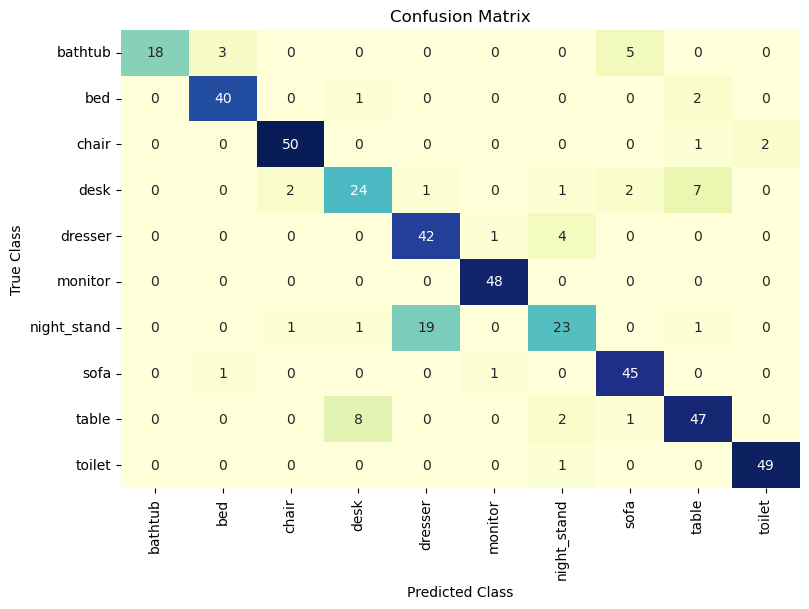

In [57]:
#@title Evaluate
#@markdown Dataset to evaluate:
dataset = valid_dataloader #@param ["valid_dataloader", "test_dataloader","train_dataloader"] {type:"raw"}
evaluate_network(dataset, model_eval, "Validation Dataset") #train_dataloader

In [56]:
#@title Reloading the last saved model
# Evaluating saved model, need to reload otherwise you will evaluate on the last updates done on the model while training
model_eval = getBlankModel()

modelEvalName = modelFileName        #vgnet_v3_adam_1e-03.pt (OPT now)

logger.info(f"loading model_eval from {modelEvalName}")
model_eval.load_state_dict(torch.load(modelEvalName,map_location=torch.device(device))) #,map_location=torch.device('cpu'))) #))
model_eval.to(device)
print(f"Loaded model from {modelEvalName}")
#
## OLD TRAINED MODEL, from GDrive
# print(f"loading model {TRAINED_MODEL_PATH}")
# logger.info(f"\loading model_eval from @ {TRAINED_MODEL_PATH}")
# model_eval.load_state_dict(torch.load(TRAINED_MODEL_PATH,map_location=torch.device(device))) #,map_location=torch.device('cpu'))) #))
# model_eval.to(device)

Loaded model from /kaggle/working/NNDL/Model/Orion/vgnetorion_extended_adam_1e-03.pt


y_pred: [5, 2, 0, 1, 5, 3, 1, 4, 7, 8, 5, 4, 9, 4, 7, 1, 4, 3, 1, 9, 9, 3, 8, 7, 8, 3, 7, 5, 1, 4, 4, 5, 0, 4, 6, 5, 8, 2, 7, 7, 3, 4, 8, 3, 3, 4, 8, 0, 5, 9, 4, 4, 6, 6, 2, 6, 8, 7, 6, 3, 7, 2, 4, 2, 9, 3, 6, 1, 2, 9, 3, 6, 5, 2, 2, 4, 4, 1, 5, 1, 1, 0, 0, 9, 4, 7, 6, 9, 6, 3, 2, 3, 2, 7, 7, 7, 2, 1, 0, 8, 4, 8, 8, 5, 4, 1, 4, 8, 8, 4, 7, 5, 8, 6, 2, 2, 7, 3, 5, 2, 7, 2, 9, 8, 1, 7, 0, 4, 4, 2, 7, 9, 5, 5, 5, 5, 9, 5, 4, 4, 4, 5, 0, 1, 9, 8, 8, 9, 1, 3, 5, 4, 4, 5, 3, 9, 8, 2, 5, 2, 6, 5, 2, 1, 9, 4, 7, 2, 8, 8, 4, 9, 4, 5, 7, 7, 0, 0, 5, 6, 9, 8, 9, 4, 9, 6, 8, 6, 3, 3, 7, 3, 1, 8, 5, 7, 7, 2, 5, 1, 7, 4, 6, 8, 0, 8, 3, 7, 3, 7, 9, 2, 4, 6, 1, 5, 5, 7, 8, 1, 9, 5, 9, 0, 9, 4, 1, 7, 2, 1, 3, 7, 5, 9, 0, 8, 2, 6, 6, 2, 2, 2, 8, 7, 7, 7, 2, 4, 8, 6, 1, 3, 9, 4, 1, 4, 7, 0, 8, 9, 8, 3, 1, 8, 8, 4, 4, 8, 1, 9, 7, 5, 5, 0, 4, 2, 8, 2, 3, 9, 4, 6, 6, 5, 4, 5, 2, 2, 8, 9, 1, 4, 4, 5, 8, 6, 4, 6, 8, 5, 1, 1, 8, 4, 2, 8, 4, 1, 1, 3, 2, 7, 1, 8, 7, 1, 4, 6, 5, 8, 2, 7, 7, 3, 9, 2, 3, 1, 7, 9, 9

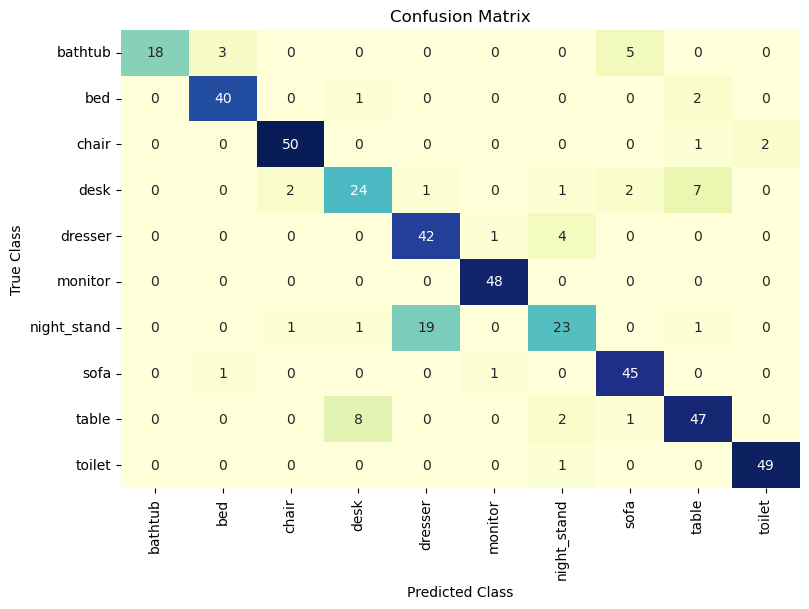

In [57]:
#@title Evaluate
#@markdown Dataset to evaluate:
dataset = valid_dataloader #@param ["valid_dataloader", "test_dataloader","train_dataloader"] {type:"raw"}
evaluate_network(dataset, model_eval, "Validation Dataset") #train_dataloader